In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from csgan.loader.colored_mnist_loader import ColoredMnistDataset
from csgan.model.cs_double_encoder_model import CSDoubleEconderMnistModel

In [3]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [4]:
run_dir = os.path.join(RUN_ROOT, "mnist_cs_double_encoder/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 32, 'test_batch_size': 512,
          'learning_rate': 0.0002, 'beta1': 0.5, 'beta2': 0.999,
          'scheduler_gamma': 1., 'weight_decay': 0., #0.00001,
          'lambda_identity': 5., 'lambda_cycle': 10., 'lambda_content': 0.1, 'lambda_style': 0.,
          'lambda_source': 0.1, 'lambda_reference': 0.1, 'lambda_content_seg': 0., 'lambda_style_seg': 0.,
          'lambda_siamese': 1.,
          'gamma_content': 1., 'gamma_style': 1., 'gamma_source': 1., 'gamma_reference': 1.,
          'gamma_content_seg': 1., 'gamma_style_seg': 1., 
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [5]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

1875 20


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cs_model = CSDoubleEconderMnistModel(device)
#cs_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
cs_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00020000.

[1/200] 10'th step. [LOSS] 8.652725. [LOSS_IDENTITY] 2.363062. [LOSS_CYCLE] 4.536212. [LOSS_CONTENT] 0.074393. [ACCURACY_CONTENT] 0.562500. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.024189. [ACCURACY_SOURCE] 1.000000. [LOSS_REFERENCE] 0.021935. [ACCURACY_REFERENCE] 1.000000. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.500000. [LOSS_SIAMESE] 1.377331. [NORM_S1] 0.523627. [NORM_S2] 0.581502
    Best Step:     10. Elapsed Time: 7.179310 seconds.
[1/200] 20'th step. [LOSS] 5.367689. [LOSS_IDENTITY] 1.362062. [LOSS_CYCLE] 2.665920. [LOSS_CONTENT] 0.071814. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.020471. [ACCURACY_SOURCE] 1.000000. [LOSS_REFERENCE] 0.015720. [ACCURACY_REFERENCE] 0.984375. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.50000

KeyboardInterrupt: 

In [ ]:
all_input, all_output = cs_model.predict(test_loader)

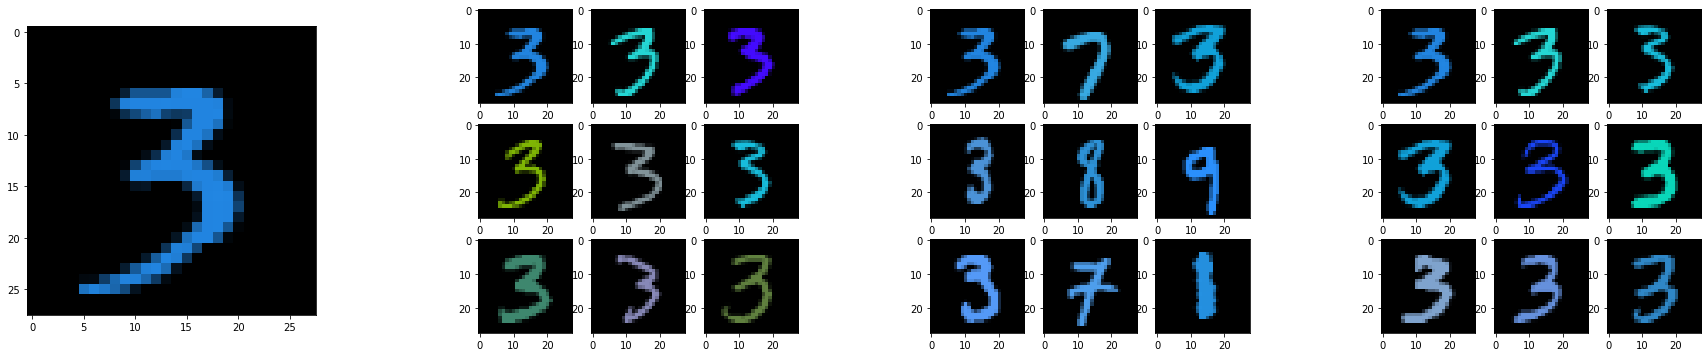

In [17]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()